In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
ecg_data = pd.read_csv(PATH_TO_DATA, header=None)

In [ ]:
scaler = StandardScaler()

In [ ]:
X = scaler.fit_transform(ecg_data.values)
x_train, x_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
input_dim = x_train.shape[1]

In [ ]:
# Build Autoencoder
encoder = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(8, activation="relu")
])

In [ ]:
decoder = keras.Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(input_dim, activation="linear")
])

In [ ]:
autoencoder = keras.Sequential([encoder, decoder])

In [ ]:
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 8)                   │           4,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 141)                 │           4,941 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,749 (38.08 KB)

 Trainable params: 9,749 (38.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer="adam", loss="mse")
history = autoencoder.fit(x_train, x_train, epochs=3, batch_size=32, shuffle=True, validation_data=(x_test,x_test))

Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.8605 - val_loss: 0.3523
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2987 - val_loss: 0.2364
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2406 - val_loss: 0.2121


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print(f"Training Loss: {train_loss[-1]:.4f}")
print(f"Validation Loss: {val_loss[-1]:.4f}")

Training Loss: 0.2262
Validation Loss: 0.2121


In [ ]:
# Detect Anomalies
y_pred = autoencoder.predict(x_test)
mse = np.mean(np.square(x_test - y_pred), axis=1)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold
num_anomalies = np.sum(anomalies)
print(f"Number of Anomalies: {num_anomalies}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Number of Anomalies: 50


In [ ]:
# Evaluation Metrics
y_true = np.zeros(len(x_test))
y_true[anomalies] = 1
y_pred_labels = (mse > threshold).astype(int)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels))


Confusion Matrix:
[[950   0]
 [  0  50]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       950
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



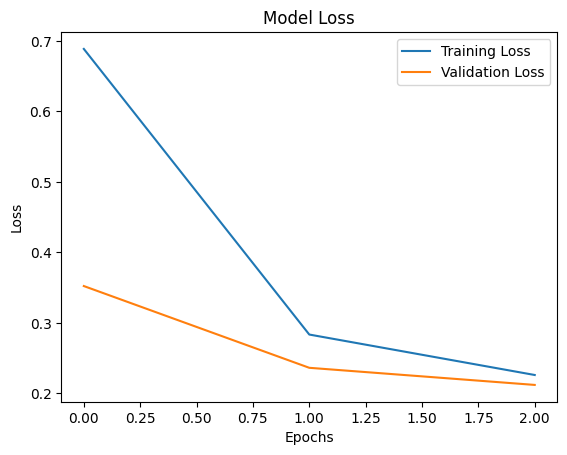

In [ ]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

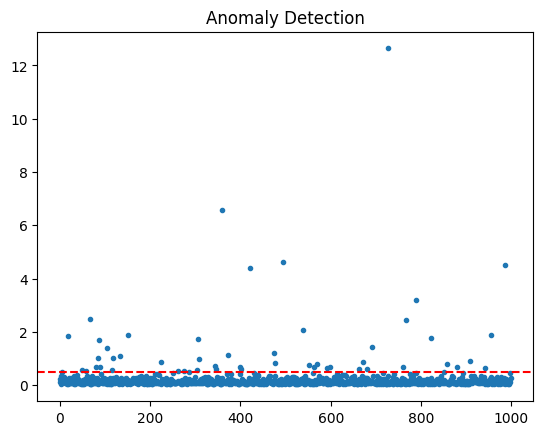

In [ ]:
# Plot Anomalies
plt.plot(mse, 'o', markersize=3)
plt.axhline(threshold, color='r', linestyle='--')
plt.title('Anomaly Detection')
plt.show()

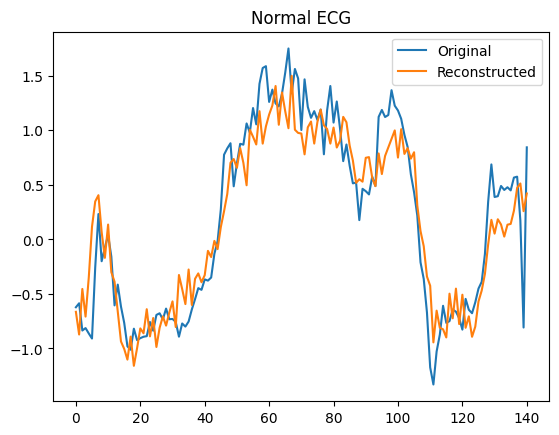

In [ ]:
# Visualize Normal and Anomalous ECG
plt.plot(x_test[1], label='Original')
plt.plot(y_pred[1], label='Reconstructed')
plt.title('Normal ECG')
plt.legend()
plt.show()


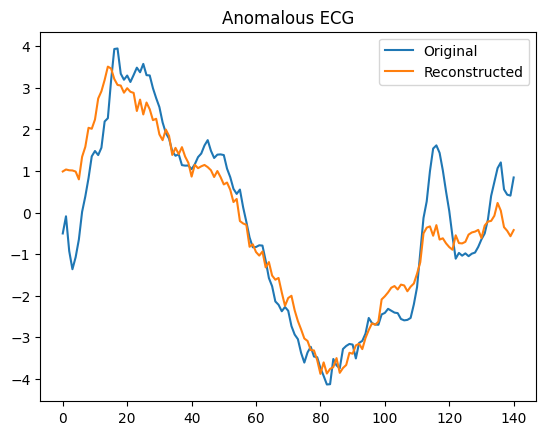

In [ ]:
if num_anomalies > 0:
    plt.plot(x_test[anomalies][1], label='Original')
    plt.plot(y_pred[anomalies][1], label='Reconstructed')
    plt.title('Anomalous ECG')
    plt.legend()
    plt.show()